<a href="https://colab.research.google.com/github/aarnavg54/Arterial-Vessels-U-Net/blob/main/Statistical_Analysis%20%2B%20Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Statistical Analysis**

This Colab Notebook contains all the code for our statistical analyses and diagram visualizations. Our Dice and IoU dataset can be found here: https://docs.google.com/spreadsheets/d/1AsvfX7sE5zgSe-Nj4FEvA2UHL6H16pwmsl4KCmkXGDw/edit?gid=0#gid=0

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Arterial_Vessel_Data.csv to Arterial_Vessel_Data.csv


In [3]:
import pandas as pd

In [4]:
import io
# Creating a dataframe
df = pd.read_csv(io.BytesIO(uploaded["Arterial_Vessel_Data.csv"]))

In [5]:
df.head()

,Name,Diameter,Dice,IOU
0,MA2_77L3_11_х10.png,139.117770,0.053735,0.027609
1,MA19_62L3_4_х10.png,372.480097,0.621559,0.450914
2,MA4_75L4_8_х10.png,108.898350,0.222832,0.125386
3,VZ0_69_24__х10.png,162.584260,0.470155,0.307322
4,VN1_50L3_1.png,167.110000,0.570545,0.399134


In [6]:
# Dividing the diameters into 3 groups
groups = ["small", "medium", "large"]

# Apply qcut and create a new column of data
df['diameter_groups'] = pd.qcut(df["Diameter"], q = 3, labels=groups)

df.head()

,Name,Diameter,Dice,IOU,diameter_groups
0,MA2_77L3_11_х10.png,139.117770,0.053735,0.027609,medium
1,MA19_62L3_4_х10.png,372.480097,0.621559,0.450914,large
2,MA4_75L4_8_х10.png,108.898350,0.222832,0.125386,medium
3,VZ0_69_24__х10.png,162.584260,0.470155,0.307322,large
4,VN1_50L3_1.png,167.110000,0.570545,0.399134,large


In [7]:
df['diameter_groups'].value_counts()

,count
diameter_groups,
small,41
large,41
medium,40


In [72]:
# Calculating the mean of each diameter group for Dice and IoU
mean_group_dice = df.groupby('diameter_groups', observed = False)['Dice'].mean()
mean_group_iou = df.groupby('diameter_groups', observed = False)['IOU'].mean()

# Print the results
print("Mean Dice scores by diameter group:")
print(mean_group_dice);
print("\nMean IoU scores by diameter group:")
print(mean_group_iou);

Mean Dice scores by diameter group:
diameter_groups
small     0.206804
medium    0.298700
large     0.473614
Name: Dice, dtype: float64

Mean IoU scores by diameter group:
diameter_groups
small     0.122408
medium    0.191057
large     0.341769
Name: IOU, dtype: float64


In [9]:
# Filtering the groups from the original dataframe for Dice
small_group_dice = df[df["diameter_groups"] == "small"]["Dice"]
medium_group_dice = df[df["diameter_groups"] == "medium"]["Dice"]
large_group_dice = df[df["diameter_groups"] == "large"]["Dice"]

# Filtering the groups from the original dataframe for IoU
small_group_iou= df[df["diameter_groups"] == "small"]["IOU"]
medium_group_iou = df[df["diameter_groups"] == "medium"]["IOU"]
large_group_iou = df[df["diameter_groups"] == "large"]["IOU"]

# These variables will be used for all future group comparisons

#### **Shapiro-Wilk Test for Dice & IoU Groups**
This test is used to determine whether a datset is normally distributed or not. We are focusing on the small, medium, and large groups

In [10]:
from scipy.stats import shapiro

# Normality assumptions for Dice
print("Shapiro-Wilk for Dice:")
for name, group in [("Small", small_group_dice), ("Medium", medium_group_dice), ("Large", large_group_dice)]:
    stat, p = shapiro(group)
    print(f"{name}: W = {stat}, p = {p}")

# p > 0.05 for all groups, indicating normal distributions

Shapiro-Wilk for Dice:
Small: W = 0.9646958078234497, p = 0.22890374375303185
Medium: W = 0.9662796183862977, p = 0.2726859635393938
Large: W = 0.9720298282693027, p = 0.4006414729465103


In [11]:
# Normality assumptions for IoU
print("Shapiro-Wilk for IoU:")
for name, group in [("Small", small_group_iou), ("Medium", medium_group_iou), ("Large", large_group_iou)]:
    stat, p = shapiro(group)
    print(f"{name}: W = {stat}, p = {p}")

# p < 0.05 for all groups, indicating non-normal distributions

Shapiro-Wilk for IoU:
Small: W = 0.9441111599124822, p = 0.04357739674680247
Medium: W = 0.9233762491611397, p = 0.009849287240392319
Large: W = 0.9377983672247513, p = 0.026424930481424396


#### **Levene's Test for Dice & IoU**
This test is used to assess the equality of variance for a dataset

In [12]:
from scipy import stats

# Levene's test for Dice
levene_statistic, p_value = stats.levene(small_group_dice, medium_group_dice, large_group_dice)
print(f"Levene Statistic for dice: {levene_statistic}")
print(f"p-value for dice: {p_value}")

# p < 0.05, violating assumptions of homogeneous variances

Levene Statistic for dice: 4.901304520035776
p-value for dice: 0.009005895828103272


In [13]:
# Levene's test for IoU
levene_statistic, p_value = stats.levene(small_group_iou, medium_group_iou, large_group_iou)
print(f"Levene Statistic for IoU: {levene_statistic}")
print(f"p-value for IoU: {p_value}")

# p < 0.05, violating assumptions of homogeneous variances

Levene Statistic for IoU: 9.616851844819982
p-value for IoU: 0.00013443567199220087


#### **Welch's ANOVA test with Games-Howell Post-Hoc for Dice**
Welch's ANOVA test is used when assumptions of homogenous variances are violated and all groups are normally distributed. Games-Howell post-hoc is used after a signficiant Welch's ANOVA test

In [14]:
# This library is required for various statistical tests
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.2 MB/s eta 0:00:00


In [15]:
import pingouin as pg

# Welch's ANOVA for Dice
welch_anova = pg.welch_anova(dv='Dice', between='diameter_groups', data=df)
print("Welch’s ANOVA Result:")
welch_anova

# p < 0.000001 indicates statistically signficant disparities

Welch’s ANOVA Result:


,Source,ddof1,ddof2,F,p-unc,np2
0,diameter_groups,2,76.029626,19.930813,1.098277e-07,0.258198


In [16]:
# Games-Howell post-hoc due to significant Welch's ANOVA results
games_howell = pg.pairwise_gameshowell(dv='Dice', between='diameter_groups', data=df)
print("Games-Howell Results:")
games_howell

# There are signficiant results between small vs. medium, small vs. large, and medium vs. large

Games-Howell Results:


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,small,medium,0.206804,0.298700,-0.091896,0.037239,-2.467749,72.128181,4.175920e-02,-0.545144
1,small,large,0.206804,0.473614,-0.266810,0.042225,-6.318838,66.407537,7.557401e-08,-1.382473
2,medium,large,0.298700,0.473614,-0.174914,0.046833,-3.734819,76.831969,1.035173e-03,-0.820142


#### **Kruskal-Wallis and Dunn's Post-Hoc for IoU**
The Kuskal-Wallis test is used when no data group is normally distributed and doesn't rely on homogenous variances. Dunn's post-hoc is used after a signficiant Kruskal-Wallis test.

In [17]:
from scipy.stats import kruskal

# Kruskal-Wallis test for IoU
stat, p_value = kruskal(small_group_iou, medium_group_iou, large_group_iou)
print(f"Kruskal-Wallis H-statistic: {stat}, p-value: {p_value}")

# p < 0.000001 indicates signficant disparities

Kruskal-Wallis H-statistic: 29.20698044297407, p-value: 4.54762641344007e-07


In [23]:
# This library is required for dunn's post-hoc
!pip install scikit-posthocs

In [30]:
import scikit_posthocs as sp

# Dunn's post-hoc due to significant Kruskal-Wallis results
dunn_post_hoc = sp.posthoc_dunn(df, val_col = "IOU", group_col = "diameter_groups", p_adjust = "bonferroni")
print("Dunn's Post-Hoc Results:")
dunn_post_hoc

# There are signficiant differences between large vs. small and large vs. medium; none between small vs. medium

Dunn's Post-Hoc Results:


,small,medium,large
small,1.000000e+00,0.106456,2.425319e-07
medium,1.064556e-01,1.000000,3.723650e-03
large,2.425319e-07,0.003724,1.000000e+00


In [73]:
# Calculating the z-score for Dunn's post-hoc. This determines the magnitude, or extent of difference between each group
from scipy.stats import rankdata
import itertools
import numpy as np

# Creating a ranked column of Dice
df['rank'] = rankdata(df['Dice'])

# Counting how many sampels are in each group
group_n = df['diameter_groups'].value_counts()

# Average rank per group
group_ranks = df.groupby('diameter_groups', observed = True)['rank'].mean()  # group name → mean rank

# Total sample size
N = len(df)

# A function for pooled standard error
def pooled_std(n1, n2, N):
    return np.sqrt((N * (N + 1)) / 12 * (1/n1 + 1/n2))

# Calculating z-scores for each group pair
z_scores = {}
for g1, g2 in itertools.combinations(groups, 2):
    R1 = group_ranks[g1]
    R2 = group_ranks[g2]
    n1 = group_n[g1]
    n2 = group_n[g2]
    z = (R1 - R2) / pooled_std(n1, n2, N)
    z_scores[f'{g1} vs {g2}'] = z

# Printing results; absolute value of z since it should be +
for comparison, z in z_scores.items():
    print(f"{comparison}: z = {abs(z)}");


small vs medium: z = 2.102708327674816
small vs large: z = 5.365057554261349
medium vs large: z = 3.2291287365594696


#### **Shapiro-Wilk Test for Dice & IoU**
We are now disregarding the small, medium, and large groups

In [42]:
# Extract all Dice values
all_dice = df["Dice"]

# Run Shapiro-Wilk Test
stat, p = shapiro(all_dice)

print("Shapiro-Wilk Test on all Dice Values:")
print(f"W = {stat}, p = {p}")

# Since p < 0.05, the entire dataset follows a non-normal distribution

Shapiro-Wilk Test on all Dice Values:
W = 0.9544757149518344, p = 0.00041316657663514195


In [43]:
# Extract all IoU values
all_iou = df["IOU"]

# Run Shapiro-Wilk Test
stat, p = shapiro(all_iou)

print("Shapiro-Wilk Test on all IoU Values:")
print(f"W = {stat}, p = {p}")

# Since p < 0.05, the entire dataset follows a non-normal distribution

Shapiro-Wilk Test on all IoU Values:
W = 0.8824595750171184, p = 2.2398767690428268e-08


#### **Spearman & Pearson Correlation Between Diameter & Dice/ IoU**
The Spearman correlation coefficient doesn't assume normality, whereas the Pearson correlation coefficient does.

In [46]:
# Spearman correlation for Dice
from scipy.stats import spearmanr
spearman_rank_dice, p_value = spearmanr(df["Diameter"], df["Dice"])
print(f"Spearman's correlation coefficient: {spearman_rank_dice}")
print("P-value:", p_value)

Spearman's correlation coefficient: 0.5422109575976708
P-value: 1.1159807939981434e-10


In [47]:
# Spearman correlation for IoU
from scipy.stats import spearmanr
spearman_rank_iou, p_value = spearmanr(df["Diameter"], df["IOU"])
print(f"Spearman's correlation coefficient: {spearman_rank_iou}")
print("P-value:", p_value)

Spearman's correlation coefficient: 0.5422109575976708
P-value: 1.1159807939981434e-10


In [52]:
# Pearson coefficient for Dice
correlation_matrix_dice = np.corrcoef(df["Diameter"], df["Dice"])
print("Pearson correlation coefficient for dice:", correlation_matrix_dice[0, 1])

Pearson correlation coefficient for dice: 0.6185717007987391


In [53]:
# Pearson coefficient for Dice
correlation_matrix_iou = np.corrcoef(df["Diameter"], df["IOU"])
print("Pearson correlation coefficient for IoU:", correlation_matrix_iou[0, 1])

Pearson correlation coefficient for IoU: 0.6655424998942226


# **Diagram Visualizations**

#### **Distribution of DSC and IoU Values across the Arterial Vessel Groups**

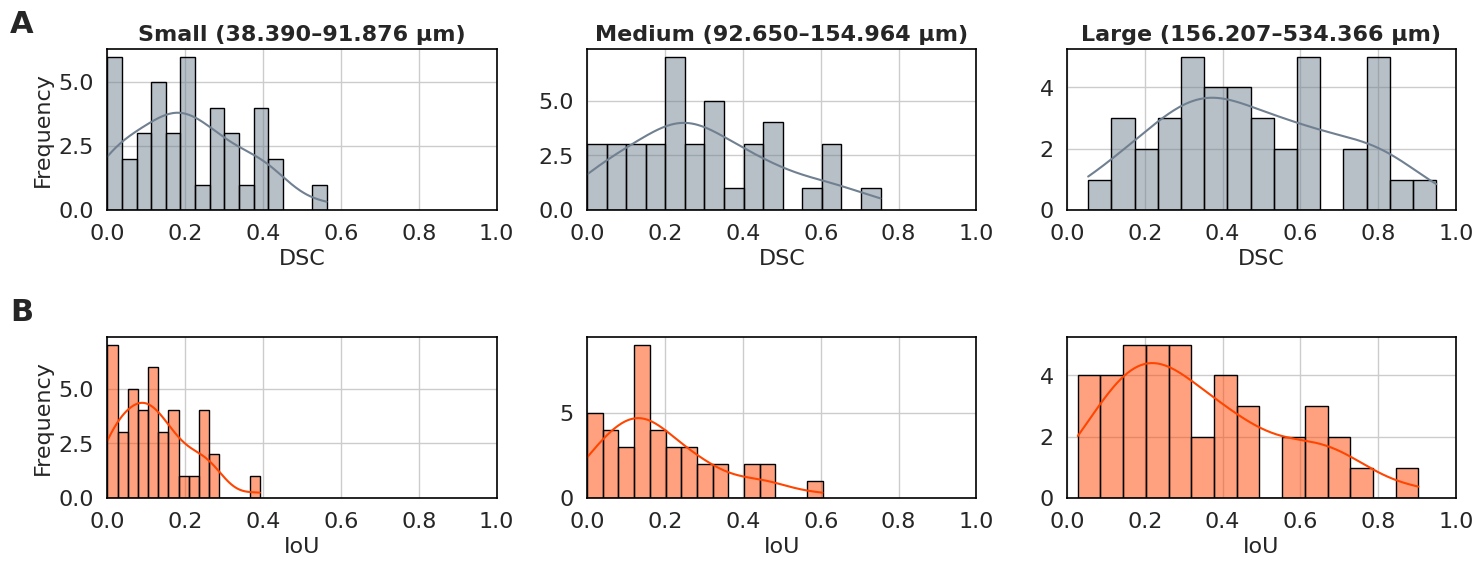

In [58]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Setting the plot style
sns.set(style="whitegrid", font_scale=1.0)
plt.rcParams.update({'axes.titlesize': 16,'axes.labelsize': 16,'xtick.labelsize': 16,'ytick.labelsize': 16,'legend.fontsize': 16,'font.size': 16,'axes.edgecolor': 'black','axes.linewidth': 1.2})

# Create a figure and 2x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 6), sharey=False)

# Titles with diameter ranges
titles = {
    'Small': 'Small (38.390–91.876 µm)',
    'Medium': 'Medium (92.650–154.964 µm)',
    'Large': 'Large (156.207–534.366 µm)'
}

# Row 1: Dice scores
for ax, data, label in zip(axes[0], [small_group_dice, medium_group_dice, large_group_dice], ['Small', 'Medium', 'Large']):
    sns.histplot(data, kde=True, color='slategray', alpha=0.5, edgecolor='black', bins=15, ax=ax)
    ax.set_title(titles[label], fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_xlabel("DSC")
    ax.set_ylabel("Frequency" if label == 'Small' else '')

# Row 2: IoU scores
for ax, data, label in zip(axes[1], [small_group_iou, medium_group_iou, large_group_iou], ['Small', 'Medium', 'Large']):
    sns.histplot(data, kde=True, color='orangered', edgecolor='black', bins=15, ax=ax)
    ax.set_xlim(0, 1)
    ax.set_xlabel("IoU")
    ax.set_ylabel("Frequency" if label == 'Small' else '')

# Add row labels 'A' and 'B' for easy differentiation
axes[0, 0].text(-0.25, 1.1, "A", transform=axes[0, 0].transAxes, fontsize=22, fontweight='bold')
axes[1, 0].text(-0.25, 1.1, "B", transform=axes[1, 0].transAxes, fontsize=22, fontweight='bold')

# Displaying the plot
plt.tight_layout()
plt.show()

###**Scatterplots of Arterial Vessel Diameter vs. DSC & IoU Values**

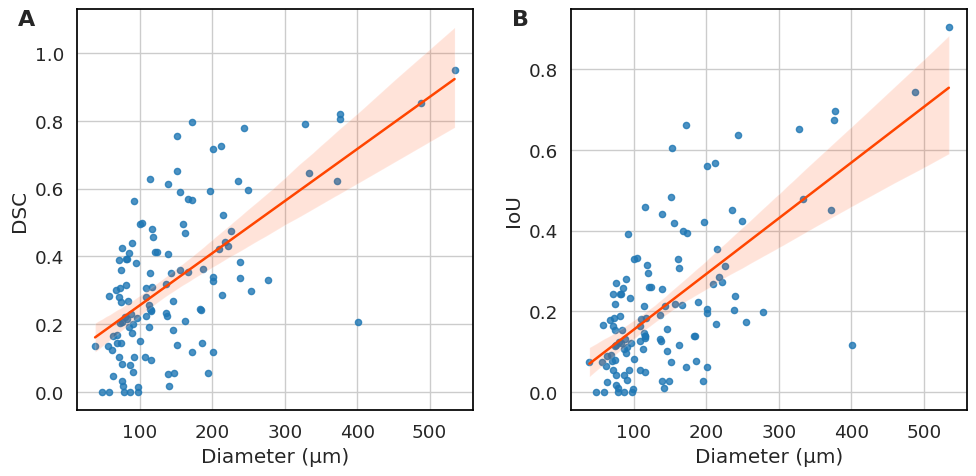

In [68]:
# Defining plot colors
dice_color = "#1f77b4"
iou_color = "#1f77b4"

x = df["Diameter"]
y1_dice = df["Dice"]
y2_iou = df["IOU"]

# Creating 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Subplot 1: Dice vs. Diameter
sns.regplot(x=x, y=y1_dice, ax=axes[0], scatter_kws={'s': 20, 'color': dice_color}, line_kws={"color": "orangered"})
axes[0].set_xlabel("Diameter (μm)")
axes[0].set_ylabel("DSC")

# Adding an A to the upper left
axes[0].text(-0.15, 1, 'A', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top')

# Subplot 2: IoU vs. Diameter
sns.regplot(x=x, y=y2_iou, ax=axes[1], scatter_kws={'s': 20, 'color': iou_color}, line_kws={"color": "orangered"})
axes[1].set_xlabel("Diameter (μm)")
axes[1].set_ylabel("IoU")

# Adding a B to the upper left
axes[1].text(-0.15, 1, 'B', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top')

# Displaying the plot
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.show()

###**Boxplots of Arterial Vessel Diameter vs. DSC & IoU Values**

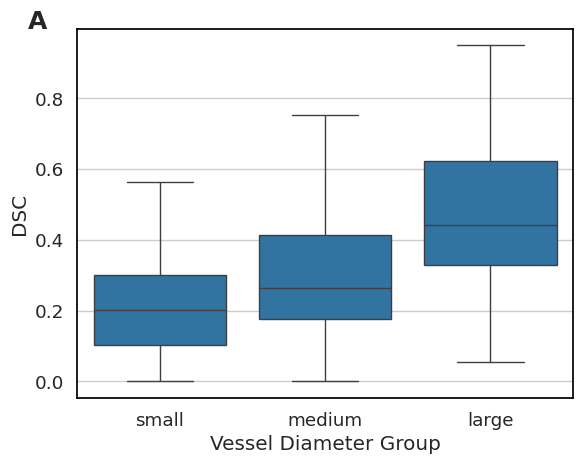

In [70]:
# Boxplot of Diameter vs. DSC
sns.boxplot(x="diameter_groups", y="Dice", data=df, color="#1f77b4")
plt.xlabel("Vessel Diameter Group")
plt.ylabel("DSC")
# Add bold 'A' in the upper-left corner
plt.text(-0.1, 1, 'A', transform=plt.gca().transAxes,fontsize=18, fontweight='bold')
plt.show()


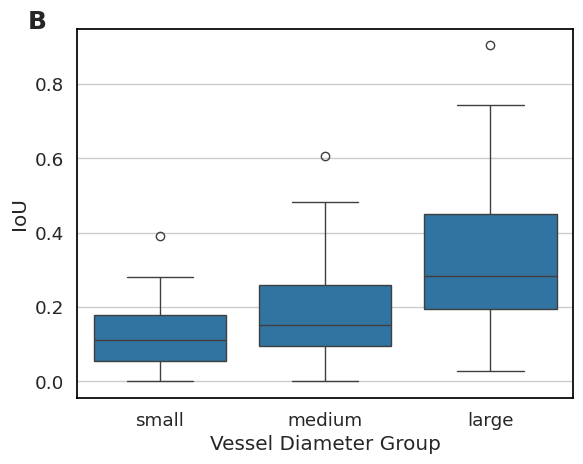

In [71]:
# Boxplot of Diameter vs. IoU
sns.boxplot(x="diameter_groups", y="IOU", data=df, color="#1f77b4")
plt.xlabel("Vessel Diameter Group")
plt.ylabel("IoU")
# Add bold 'B' in the upper-left corner
plt.text(-0.1, 1, 'B', transform=plt.gca().transAxes,fontsize=18, fontweight='bold')
plt.show()
